In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [3]:
df = pd.read_csv("International_Education_Costs.csv", encoding="ISO-8859-1", sep=";")
df.head()

,Country,City,University,Program,Level,Duration_Years,Tuition_USD,Living_Cost_Index,Rent_USD,Visa_Fee_USD,Insurance_USD,Exchange_Rate
0,USA,Cambridge,Harvard University,Computer Science,Master,2.0,55400,83.5,2200,160,1500,1.00
1,UK,London,Imperial College London,Data Science,Master,1.0,41200,75.8,1800,485,800,0.79
2,Canada,Toronto,University of Toronto,Business Analytics,Master,2.0,38500,72.5,1600,235,900,1.35
3,Australia,Melbourne,University of Melbourne,Engineering,Master,2.0,42000,71.2,1400,450,650,1.52
4,Germany,Munich,Technical University of Munich,Mechanical Engineering,Master,2.0,500,70.5,1100,75,550,0.92


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 907 entries, 0 to 906
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country            907 non-null    object 
 1   City               907 non-null    object 
 2   University         907 non-null    object 
 3   Program            907 non-null    object 
 4   Level              907 non-null    object 
 5   Duration_Years     907 non-null    float64
 6   Tuition_USD        907 non-null    int64  
 7   Living_Cost_Index  907 non-null    float64
 8   Rent_USD           907 non-null    int64  
 9   Visa_Fee_USD       907 non-null    int64  
 10  Insurance_USD      907 non-null    int64  
 11  Exchange_Rate      907 non-null    float64
dtypes: float64(3), int64(4), object(5)
memory usage: 85.2+ KB


In [5]:
df["Total_Cost_USD"] = (df["Tuition_USD"] + df["Rent_USD"] + df["Insurance_USD"] + df["Visa_Fee_USD"])

top_cities = (df.groupby("City")["Living_Cost_Index"].mean().sort_values(ascending=False).head(5).index)

# Step 3: Filter data for these top cities
top_city_data = df[df["City"].isin(top_cities)]

# Step 4: Compute average total cost per city
average_total_costs = (top_city_data.groupby("City")["Total_Cost_USD"].mean().sort_values(ascending=False))

print(average_total_costs)

City
New York      63093.333333
Zurich         4844.000000
Lausanne       4694.000000
Geneva         4654.000000
St. Gallen     4384.000000
Name: Total_Cost_USD, dtype: float64


In [6]:
import streamlit as st
import pandas as pd
import plotly.express as px


# Sidebar filters
country = st.sidebar.selectbox("Select Country", sorted(df['Country'].unique()))
level = st.sidebar.selectbox("Select Program Level", sorted(df['Level'].unique()))

# Filter data
filtered_df = df[(df['Country'] == country) & (df['Level'] == level)]

# Metrics
st.title("University Program Cost Dashboard")
st.metric("Average Tuition (USD)", f"${filtered_df['Tuition_USD'].mean():,.0f}")
st.metric("Average Rent (USD)", f"${filtered_df['Rent_USD'].mean():,.0f}")
st.metric("Avg. Duration (Years)", f"{filtered_df['Duration_Years'].mean():.1f} years")

# Tuition Chart
fig = px.bar(
    filtered_df.sort_values('Tuition_USD', ascending=False).head(10),
    x='University',
    y='Tuition_USD',
    color='City',
    title=f"Top 10 Universities by Tuition in {country} ({level})"
)
st.plotly_chart(fig)

# Living Cost Index
fig2 = px.scatter(
    filtered_df,
    x='Living_Cost_Index',
    y='Rent_USD',
    size='Tuition_USD',
    color='City',
    hover_name='University',
    title="Living Cost Index vs Rent (Bubble = Tuition)"
)
st.plotly_chart(fig2)


2025-05-22 13:04:20.794 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 13:04:20.794 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 13:04:20.801 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 13:04:20.803 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-05-22 13:04:20.803 WARNING streamlit.runtime.state.session_state_proxy: Session state does not function when running a script without `streamlit run`
2025-05-22 13:04:20.807 WARNING streamlit.runtime.scriptrunner_utils.script_run_c

DeltaGenerator()

In [7]:
df['Total_Annual_Cost'] = df['Tuition_USD'] + df['Rent_USD'] * 12 + df['Insurance_USD'] + df['Visa_Fee_USD']
df['Value_Index'] = df['Total_Annual_Cost'] / df['Living_Cost_Index']
country_value = df.groupby('Country').agg({'Value_Index': 'mean', 'Total_Annual_Cost': 'mean', 'Living_Cost_Index': 'mean'}).sort_values('Value_Index').reset_index()
country_value.columns = ['Country', 'Average Value Index', 'Average Total Annual Cost (USD)', 'Average Living Cost Index']
top_countries = country_value.head(10)
print(top_countries)
best_country = top_countries.iloc[0]

      Country  Average Value Index  Average Total Annual Cost (USD)  \
0   Argentina            97.809634                      3903.333333   
1     Algeria           106.212004                      3804.000000   
2      Greece           107.476698                      6547.058824   
3     Tunisia           119.854353                      3880.000000   
4  Bangladesh           123.504096                      4824.000000   
5     Morocco           139.578846                      5630.000000   
6      Brazil           139.637420                      7093.750000   
7       India           140.807909                      6132.500000   
8      Turkey           145.879514                      6820.000000   
9      Serbia           146.097933                      6578.000000   

   Average Living Cost Index  
0                  39.616667  
1                  35.680000  
2                  60.941176  
3                  32.266667  
4                  38.960000  
5                  40.233333  
6

In [8]:
df.describe()

,Duration_Years,Tuition_USD,Living_Cost_Index,Rent_USD,Visa_Fee_USD,Insurance_USD,Exchange_Rate,Total_Cost_USD,Total_Annual_Cost,Value_Index
count,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000
mean,2.836825,16705.016538,64.437486,969.206174,211.396913,700.077178,623.000695,18585.696803,29246.964719,429.063371
std,0.945449,16582.385275,14.056333,517.154752,143.435740,320.374875,3801.746134,17227.589033,21798.025789,281.271961
min,1.000000,0.000000,27.800000,150.000000,40.000000,200.000000,0.150000,600.000000,3100.000000,85.054348
25%,2.000000,2850.000000,56.300000,545.000000,100.000000,450.000000,0.920000,4179.000000,11475.000000,188.824383
50%,3.000000,7500.000000,67.500000,900.000000,160.000000,650.000000,1.350000,8810.000000,18590.000000,279.944290
75%,4.000000,31100.000000,72.200000,1300.000000,240.000000,800.000000,7.150000,33342.500000,46495.000000,675.002190
max,5.000000,62000.000000,122.400000,2500.000000,490.000000,1500.000000,42150.000000,66160.000000,93660.000000,1156.880734


In [9]:
df.isnull().sum()

Country              0
City                 0
University           0
Program              0
Level                0
Duration_Years       0
Tuition_USD          0
Living_Cost_Index    0
Rent_USD             0
Visa_Fee_USD         0
Insurance_USD        0
Exchange_Rate        0
Total_Cost_USD       0
Total_Annual_Cost    0
Value_Index          0
dtype: int64

In [10]:
df["Level"].value_counts()

Level
Master      451
Bachelor    297
PhD         159
Name: count, dtype: int64

In [11]:
obj=df.select_dtypes(include=['object'])
for i in obj:
    print(df[i].value_counts().head(5))

Country
UK           93
Australia    86
USA          78
Canada       76
Germany      33
Name: count, dtype: int64
City
Singapore    18
Sydney       11
Melbourne    11
London       10
Canberra      8
Name: count, dtype: int64
University
University of Washington           6
Stanford University                5
Australian National University     5
University of Tasmania             5
University of Western Australia    5
Name: count, dtype: int64
Program
Computer Science           312
Data Science                82
Computer Engineering        71
Software Engineering        57
Artificial Intelligence     53
Name: count, dtype: int64
Level
Master      451
Bachelor    297
PhD         159
Name: count, dtype: int64


In [12]:
df["Program"].value_counts()

Program
Computer Science           312
Data Science                82
Computer Engineering        71
Software Engineering        57
Artificial Intelligence     53
                          ... 
Electronics                  1
Electronic Engineering       1
Digital Design               1
Digital Business             1
Data Systems                 1
Name: count, Length: 92, dtype: int64

In [13]:
def assign_program(x):
    Computer_Software = ['Computer Science','Computing Science','Computer Systems','Software Engineering','Software Development','Software Systems',
                         'Digital Innovation','Digital Design','Digital Media','Digital Business','Game Technology','Computer Networks','Computational Science',
                         'Software Science','Computer Science & Design','Computing','Computing & Innovation','Technology & Innovation']
    Data_AI = ['Data Science','Data Analytics','Data Engineering','Artificial Intelligence','Machine Learning','Business Analytics','AI Engineering',
                'Data Science & AI','Robotics & AI','Data Systems & AI','Business Informatics','Data Systems']

    Info_Security = ['Information Systems','Information Technology','Information Science','Information Security','Cybersecurity']

    Engineering_Technology = ['Engineering','Computer Engineering','Mechanical Engineering','Electrical Engineering','Electronics Engineering',
                            'Electronic Engineering','Aerospace Engineering','Chemical Engineering','Industrial Engineering','Systems Engineering',
                            'Petroleum Engineering','Energy Engineering','Environmental Engineering','Renewable Energy','Sustainable Energy',
                            'Sustainable Technology','Environmental Computing','Robotics','Robotics Engineering','Mechatronics','Engineering Physics',
                            'Engineering Management','Photonics','Digital Engineering']

    Life_Sciences = ['Physics','Mathematics','Applied Mathematics','Chemistry','Environmental Science','Climate Science','Molecular Biology',
                            'Marine Biology','Biomedical Sciences','Biotechnology','Bioinformatics','Pharmaceutical Sciences','Medicine','Neuroscience',
                            'Psychology','Forestry Sciences']

    Business_Social_Sciences = ['Business','International Business','Finance','Economics','Political Science','International Relations','Social Sciences']

    Design_Architecture = ['Architecture','Design']

    if x in Computer_Software:
        return 'Computer_Software'
    elif x in Data_AI:
        return 'Data_AI'
    elif x in Info_Security:
        return 'Info_Security'
    elif x in Engineering_Technology:
        return 'Engineering_Technology'
    elif x in Life_Sciences:
        return 'Life_Sciences'
    elif x in Business_Social_Sciences:
        return 'Business_Social_Sciences'
    elif x in Design_Architecture:
        return 'Design_Architecture'
    else:
        return 'Other'
df['Program'] = df['Program'].apply(assign_program)
df['Program'].value_counts()
    

Program
Computer_Software           414
Data_AI                     215
Engineering_Technology      128
Info_Security                73
Life_Sciences                52
Business_Social_Sciences     11
Other                        11
Design_Architecture           3
Name: count, dtype: int64

<Axes: xlabel='Level'>

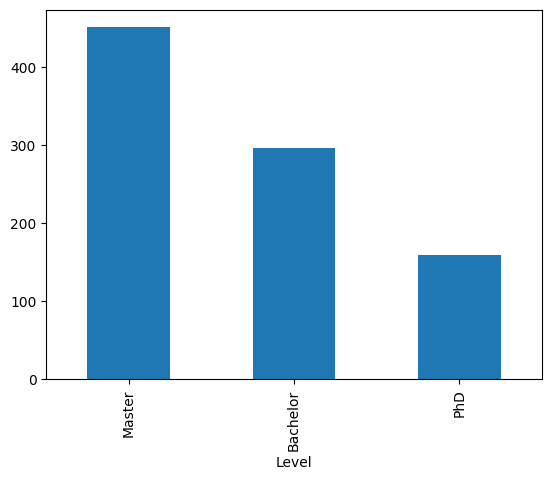

In [14]:
df['Level'].value_counts().plot(kind='bar')

In [15]:
df["University"].value_counts()

University
University of Washington           6
Stanford University                5
Australian National University     5
University of Tasmania             5
University of Western Australia    5
                                  ..
USM                                1
Universidad Politecnica            1
Imperial College                   1
ITCA-FEPADE                        1
Andijan State University           1
Name: count, Length: 622, dtype: int64

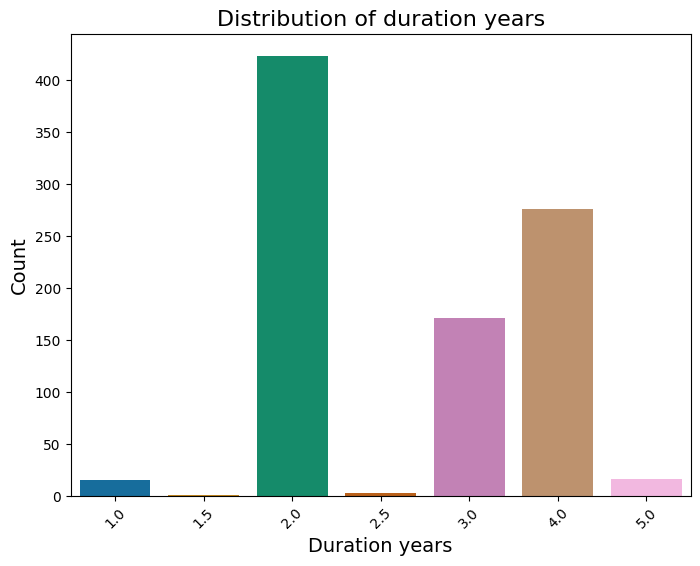

In [16]:
plt.figure(figsize=(8,6))

sns.countplot(x='Duration_Years', data=df, palette="colorblind")
plt.title('Distribution of duration years', fontsize=16)
plt.xlabel('Duration years', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

In [17]:
df["Country"].value_counts().head(10)

Country
UK             93
Australia      86
USA            78
Canada         76
Germany        33
France         27
South Korea    23
Netherlands    21
Switzerland    20
Singapore      18
Name: count, dtype: int64

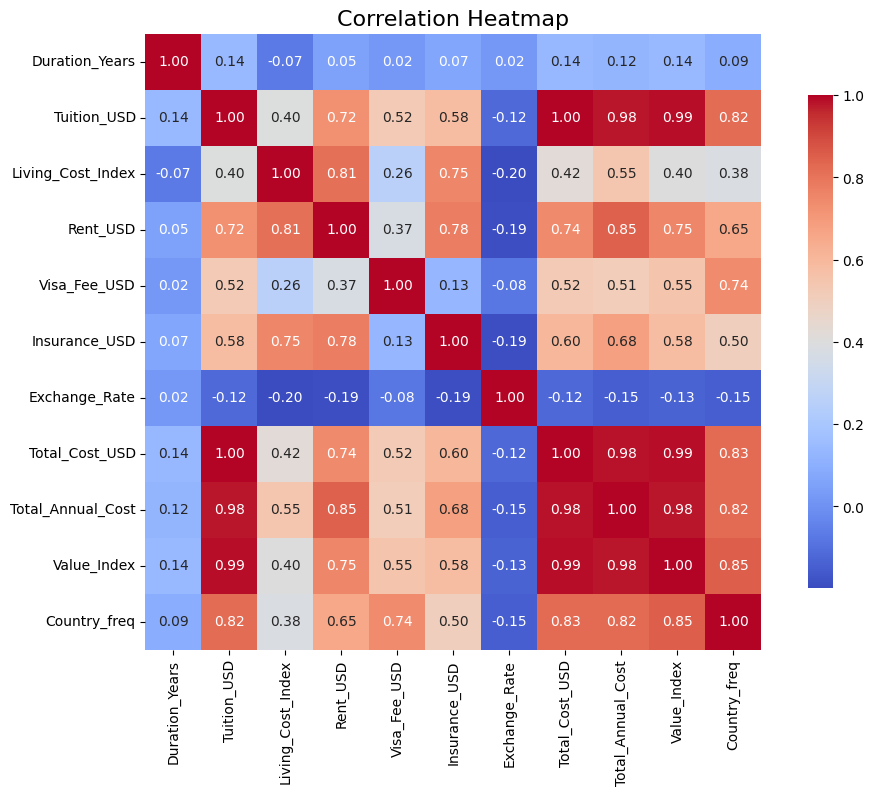

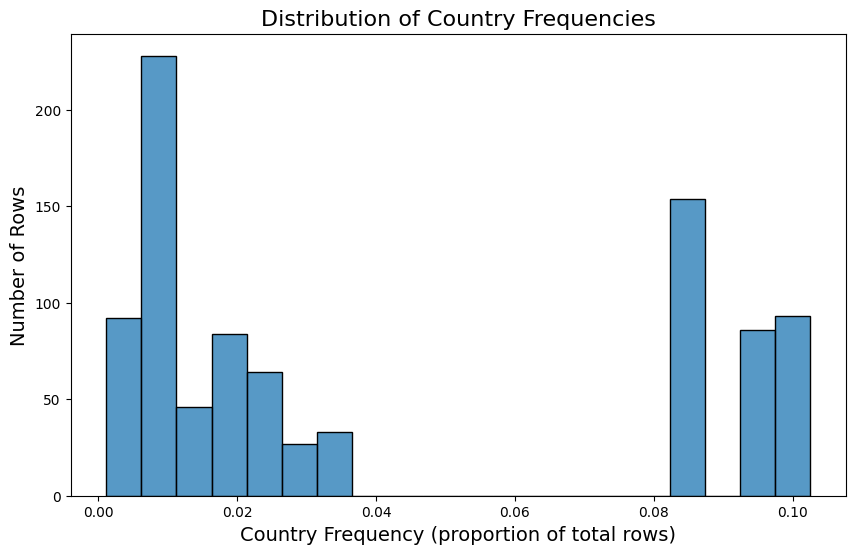

In [18]:
counts1 = df["Country"].value_counts(normalize=True)
df_freq1 = df.assign(Country_freq = df["Country"].map(counts1))

corr1 = (df_freq1.drop(columns="Country").corr(numeric_only=True))
plt.figure(figsize=(12, 8))
sns.heatmap(corr1,annot=True, fmt=".2f",cmap="coolwarm",square=True,cbar_kws={"shrink": .8})
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df_freq1["Country_freq"],bins=20,kde=False)
plt.title("Distribution of Country Frequencies", fontsize=16)
plt.xlabel("Country Frequency (proportion of total rows)", fontsize=14)
plt.ylabel("Number of Rows", fontsize=14)
plt.show()


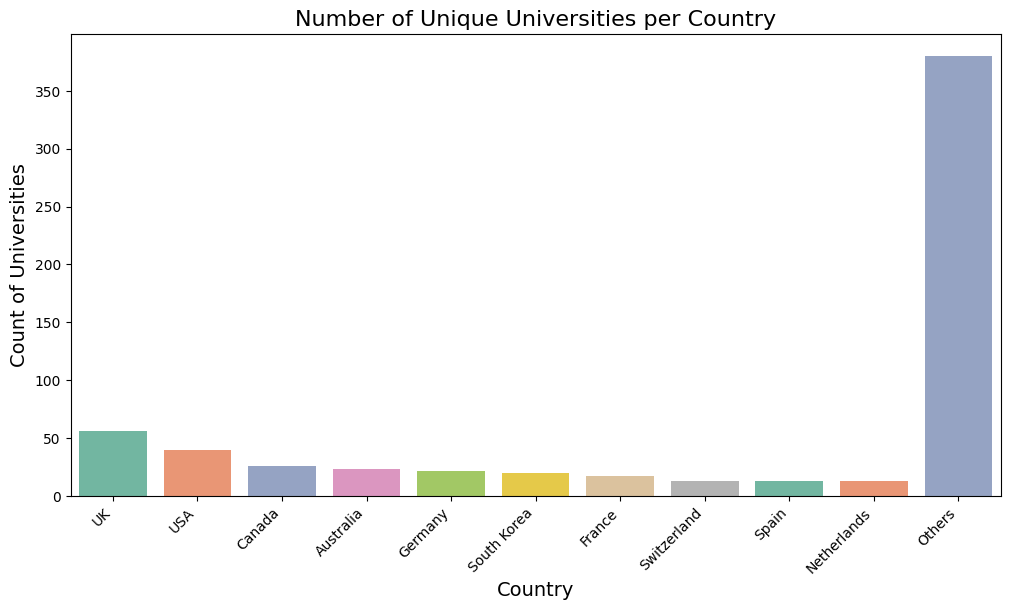

In [19]:
uni_counts = df.groupby("Country")["University"].nunique()
top_counts = uni_counts.sort_values(ascending=False).head(10)
others_count = uni_counts.sort_values(ascending=False).iloc[10:].sum()
plot_counts = pd.concat([top_counts, pd.Series({"Others": others_count})])

plt.figure(figsize=(12, 6))
sns.barplot(x=plot_counts.index, y=plot_counts.values, palette="Set2")
plt.xticks(rotation=45, ha="right")
plt.title("Number of Unique Universities per Country", fontsize=16)
plt.xlabel("Country", fontsize=14)
plt.ylabel("Count of Universities", fontsize=14)
plt.show()


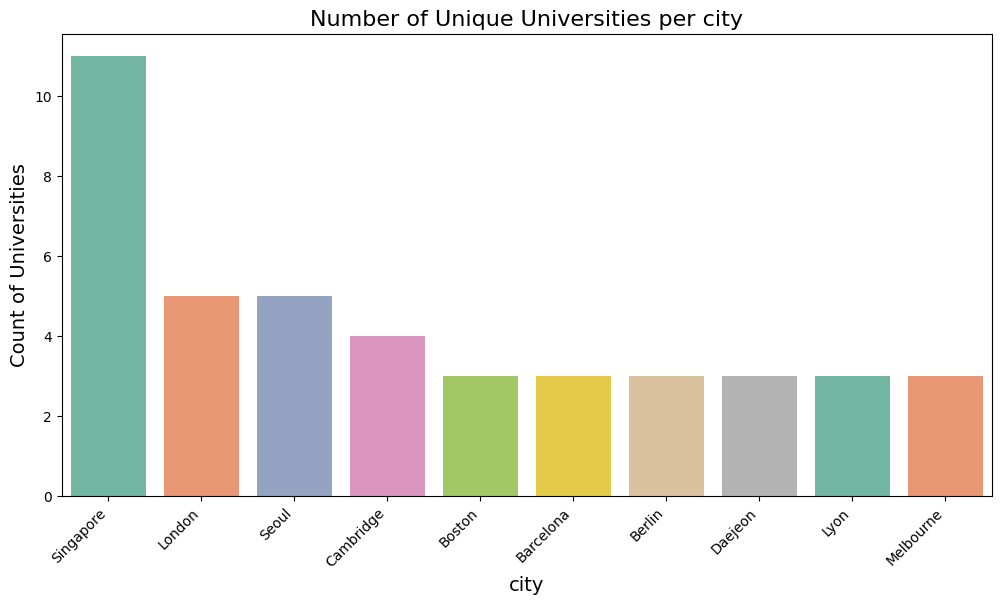

In [20]:
uni_counts2 = df.groupby("City")["University"].nunique()
top_counts2 = uni_counts2.sort_values(ascending=False).head(10)
plot_counts = pd.concat([top_counts2])

plt.figure(figsize=(12, 6))
sns.barplot(x=plot_counts.index, y=plot_counts.values, palette="Set2")
plt.xticks(rotation=45, ha="right")
plt.title("Number of Unique Universities per city", fontsize=16)
plt.xlabel("city", fontsize=14)
plt.ylabel("Count of Universities", fontsize=14)
plt.show()


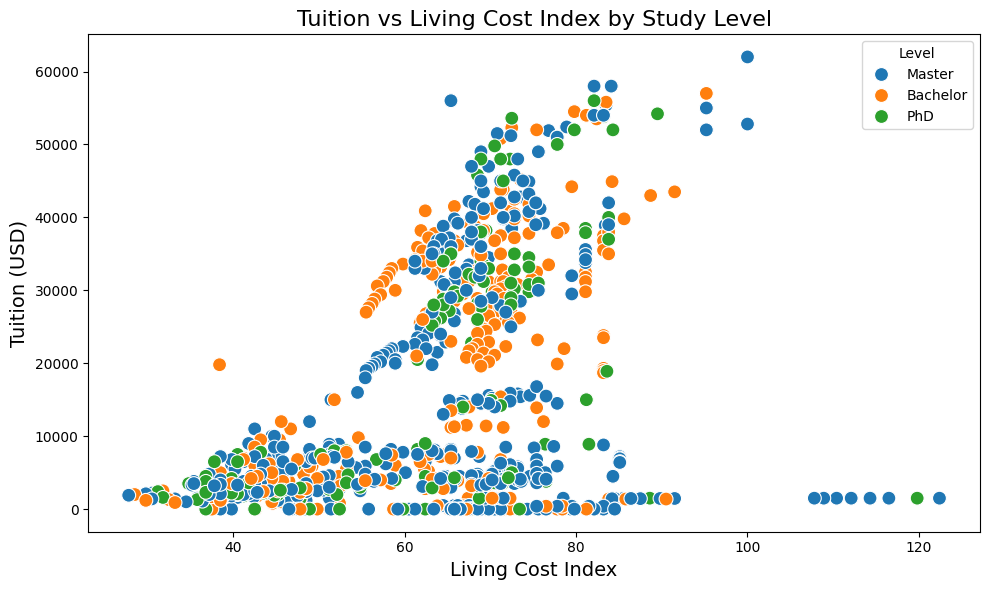

In [21]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Living_Cost_Index', y='Tuition_USD', hue='Level', s=100)
plt.title('Tuition vs Living Cost Index by Study Level', fontsize=16)
plt.xlabel('Living Cost Index', fontsize=14)
plt.ylabel('Tuition (USD)', fontsize=14)
plt.legend(title='Level')
plt.tight_layout()
plt.show()

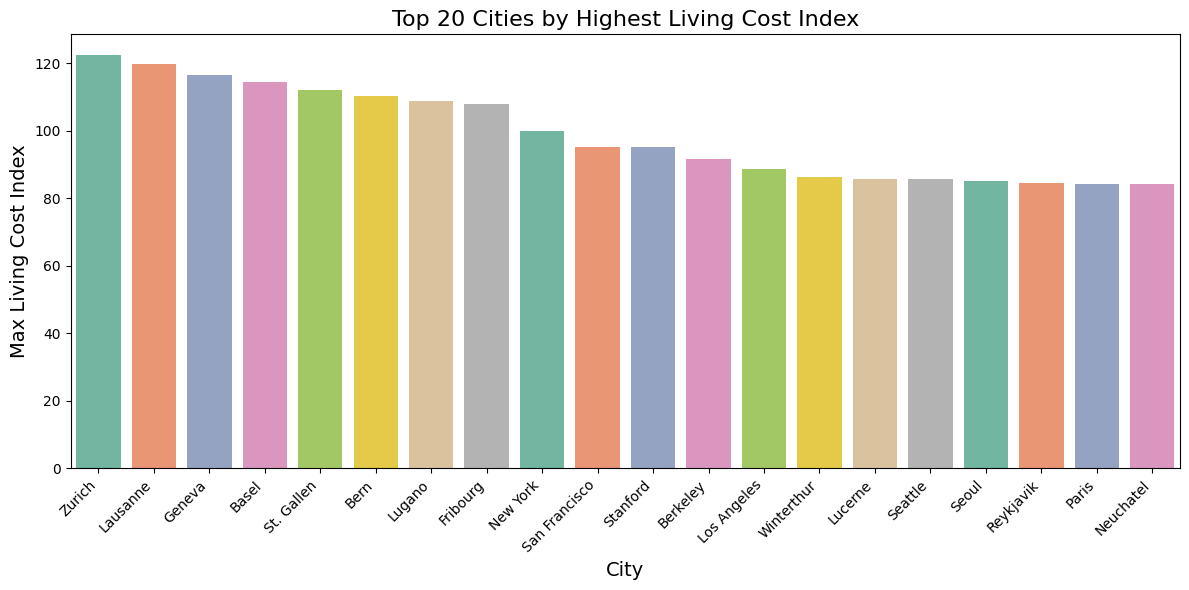

In [22]:
city_max_lci = (df.groupby("City")["Living_Cost_Index"].max().reset_index())
top_city_max = city_max_lci.sort_values("Living_Cost_Index", ascending=False).head(20)
plt.figure(figsize=(12, 6))
sns.barplot(data=top_city_max, x="City", y="Living_Cost_Index", palette="Set2")
plt.xticks(rotation=45, ha="right")
plt.title("Top 20 Cities by Highest Living Cost Index", fontsize=16)
plt.xlabel("City", fontsize=14)
plt.ylabel("Max Living Cost Index", fontsize=14)
plt.tight_layout()
plt.show()

In [23]:
Level = df['Level'].value_counts()
print(Level)

Level
Master      451
Bachelor    297
PhD         159
Name: count, dtype: int64


In [24]:
Level = {
    'Bachelor': 0,
    'Master': 1,
    'PhD': 2,
}
df['Level']=df['Level'].map(Level)

In [25]:
Level = df['Level'].value_counts()
print(Level)

Level
1    451
0    297
2    159
Name: count, dtype: int64


In [26]:
Program = {
        'Computer_Software': 0,
        'Data_AI': 1,
        'Info_Security': 2,
        'Engineering_Technology': 3,
        'Life_Sciences': 4,
        'Business_Social_Sciences': 5,
        'Design_Architecture': 6,
        'Other': 7
}
df['Program']=df['Program'].map(Program)
Program = df['Program'].value_counts()
print(Program)

Program
0    414
1    215
3    128
2     73
4     52
5     11
7     11
6      3
Name: count, dtype: int64


In [27]:
#Build the mapping dicts from the unique values
country_map = {cat: idx for idx, cat in enumerate(df["Country"].unique())}
city_map    = {cat: idx for idx, cat in enumerate(df["City"].unique())}
uni_map     = {cat: idx for idx, cat in enumerate(df["University"].unique())}

#Apply them
df["Country_code"]    = df["Country"].map(country_map)
df["City_code"]       = df["City"].map(city_map)
df["University_code"] = df["University"].map(uni_map)

#Print them
print("Country coding:\n", df["Country_code"].value_counts().head())
print("City coding:\n",    df["City_code"].value_counts().head())
print("Uni coding:\n",     df["University_code"].value_counts().head())

Country coding:
 Country_code
1    93
3    86
0    78
2    76
4    33
Name: count, dtype: int64
City coding:
 City_code
7     18
51    11
3     11
1     10
36     8
Name: count, dtype: int64
Uni coding:
 University_code
41    6
29    5
38    5
74    5
72    5
Name: count, dtype: int64


In [28]:
country_df = (
    pd.Series(country_map, name="Country_code")
      .rename_axis("Country")
      .reset_index()
)
print(country_df)

        Country  Country_code
0           USA             0
1            UK             1
2        Canada             2
3     Australia             3
4       Germany             4
..          ...           ...
66     Slovenia            66
67       Serbia            67
68         Iran            68
69   Uzbekistan            69
70  El Salvador            70

[71 rows x 2 columns]


In [29]:
city_df = (pd.Series(city_map, name="City_code").rename_axis("City").reset_index())
print(city_df)

          City  City_code
0    Cambridge          0
1       London          1
2      Toronto          2
3    Melbourne          3
4       Munich          4
..         ...        ...
551      Tabuk        551
552  Shah Alam        552
553     Makkah        553
554      Nilai        554
555    Al-Ahsa        555

[556 rows x 2 columns]


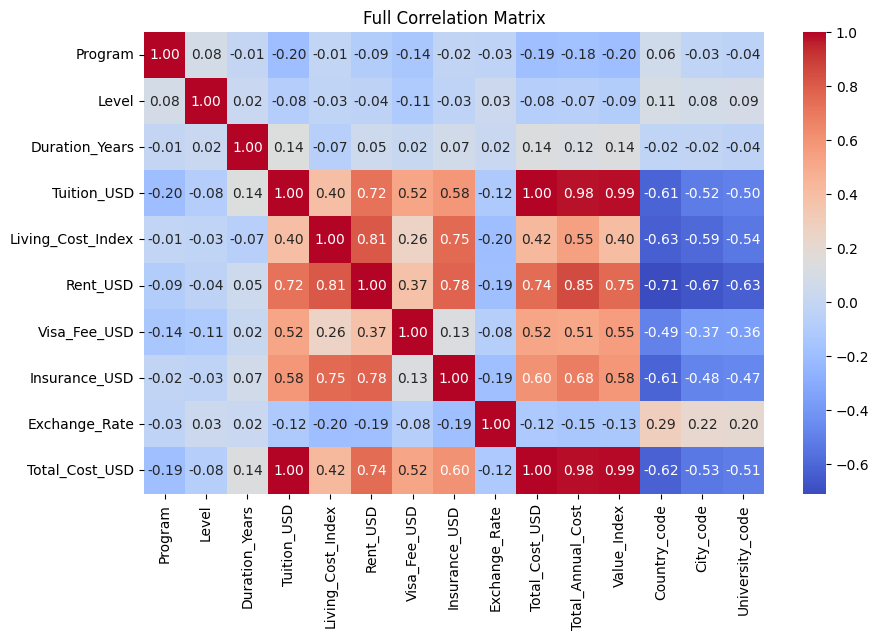

In [30]:
correlation_matrix = df.corr(numeric_only=True).head(10)
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Full Correlation Matrix")
plt.show()

In [31]:
LCI_correlation = correlation_matrix['Living_Cost_Index']
print(LCI_correlation)

Program             -0.010383
Level               -0.026430
Duration_Years      -0.068300
Tuition_USD          0.396830
Living_Cost_Index    1.000000
Rent_USD             0.811128
Visa_Fee_USD         0.256820
Insurance_USD        0.754393
Exchange_Rate       -0.198685
Total_Cost_USD       0.422485
Name: Living_Cost_Index, dtype: float64


In [32]:
features = [
    'Tuition_USD', 'Rent_USD', 'Visa_Fee_USD', 
    'Insurance_USD', 'Country_freq', 'Duration_Years'
]
target = 'Living_Cost_Index'

In [33]:
df["Living_Cost_Index"].value_counts()

Living_Cost_Index
71.2    28
68.9    28
69.8    23
65.4    22
68.5    20
        ..
34.5     1
45.5     1
49.5     1
51.5     1
50.2     1
Name: count, Length: 225, dtype: int64

In [34]:
df.groupby("Country")["Living_Cost_Index"].mean().sort_values(ascending=False).head(15)

Country
Switzerland    97.820000
Singapore      82.022222
Iceland        81.750000
Luxembourg     78.900000
Hong Kong      78.600000
USA            77.796154
Israel         76.200000
South Korea    74.752174
Denmark        73.720000
New Zealand    72.866667
Norway         72.327273
Ireland        71.710000
France         71.651852
Belgium        71.311111
Austria        71.066667
Name: Living_Cost_Index, dtype: float64

In [35]:
df['Insurance_USD'] = df['Insurance_USD'] / df['Duration_Years']
df['Visa_Fee_USD'] = df['Visa_Fee_USD'] / df['Duration_Years']
X = df.drop(columns=["Living_Cost_Index", "Country", "City", "University"])
Y=df["Living_Cost_Index"]

In [36]:
print(X.dtypes)

Program                int64
Level                  int64
Duration_Years       float64
Tuition_USD            int64
Rent_USD               int64
Visa_Fee_USD         float64
Insurance_USD        float64
Exchange_Rate        float64
Total_Cost_USD         int64
Total_Annual_Cost      int64
Value_Index          float64
Country_code           int64
City_code              int64
University_code        int64
dtype: object


In [37]:
# using the StandardScaler class
scaler = StandardScaler()
df['Insurance_USD'] = df['Insurance_USD'] / df['Duration_Years']
scaler.fit(X)

standarized_data = scaler.transform(X)

print(standarized_data)

X = standarized_data
Y = df["Living_Cost_Index"]

print(X)
print(Y)

[[-0.80466332  0.21969955 -0.88559636 ... -0.9214587  -1.25709066
  -1.38693868]
 [-0.14298641  0.21969955 -1.94387818 ... -0.87228459 -1.25097256
  -1.38142813]
 [-0.14298641  0.21969955 -0.88559636 ... -0.82311049 -1.24485446
  -1.37591758]
 ...
 [ 0.5186905   0.21969955 -0.88559636 ...  1.09467949  2.13845447
   2.03511156]
 [-0.80466332  1.66366687  2.2892491  ... -0.9214587  -1.01848478
  -1.16100621]
 [-0.14298641  0.21969955 -0.88559636 ... -0.87228459 -0.62692643
  -0.79731005]]
[[-0.80466332  0.21969955 -0.88559636 ... -0.9214587  -1.25709066
  -1.38693868]
 [-0.14298641  0.21969955 -1.94387818 ... -0.87228459 -1.25097256
  -1.38142813]
 [-0.14298641  0.21969955 -0.88559636 ... -0.82311049 -1.24485446
  -1.37591758]
 ...
 [ 0.5186905   0.21969955 -0.88559636 ...  1.09467949  2.13845447
   2.03511156]
 [-0.80466332  1.66366687  2.2892491  ... -0.9214587  -1.01848478
  -1.16100621]
 [-0.14298641  0.21969955 -0.88559636 ... -0.87228459 -0.62692643
  -0.79731005]]
0      83.5
1   

In [38]:
#Train & Test

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=2)
print(X.shape, X_train.shape, X_test.shape)

(907, 14) (725, 14) (182, 14)


In [39]:
#Training
model = RandomForestRegressor(
    n_estimators=264,
    min_samples_leaf= 8,
    max_features= "log2",
    max_depth=8,
    random_state=42
)

model.fit(X_train, Y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(Y_test, y_pred)
r2  = r2_score(Y_test, y_pred)

print(f"MSE:  {mse:.2f}")
print(f"R²:   {r2:.2f}")

MSE:  18.51
R²:   0.90


In [40]:

y_train_pred = model.predict(X_train)
y_test_pred  = model.predict(X_test)

#Compute metrics
mse_train = mean_squared_error(Y_train, y_train_pred)
mse_test  = mean_squared_error(Y_test,  y_test_pred)

rmse_train = mse_train**0.5
rmse_test  = mse_test**0.5

mae_train = mean_absolute_error(Y_train, y_train_pred)
mae_test  = mean_absolute_error(Y_test,  y_test_pred)

r2_train = r2_score(Y_train, y_train_pred)
r2_test  = r2_score(Y_test,  y_test_pred)

#Printing them
print(f"Train   →  MSE: {mse_train:.3f}, RMSE: {rmse_train:.3f}, MAE: {mae_train:.3f}, R²: {r2_train:.3f}")
print(f"Test    →  MSE: {mse_test:.3f},  RMSE: {rmse_test:.3f},  MAE: {mae_test:.3f},  R²: {r2_test:.3f}")


Train   →  MSE: 16.547, RMSE: 4.068, MAE: 2.719, R²: 0.918
Test    →  MSE: 18.507,  RMSE: 4.302,  MAE: 3.009,  R²: 0.899


In [41]:
df.describe()

,Program,Level,Duration_Years,Tuition_USD,Living_Cost_Index,Rent_USD,Visa_Fee_USD,Insurance_USD,Exchange_Rate,Total_Cost_USD,Total_Annual_Cost,Value_Index,Country_code,City_code,University_code
count,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000,907.000000
mean,1.216097,0.847850,2.836825,16705.016538,64.437486,969.206174,84.108508,123.565141,623.000695,18585.696803,29246.964719,429.063371,18.738699,205.470783,251.687982
std,1.512145,0.692919,0.945449,16582.385275,14.056333,517.154752,74.410086,121.192920,3801.746134,17227.589033,21798.025789,281.271961,20.347128,163.539634,181.570281
min,0.000000,0.000000,1.000000,0.000000,27.800000,150.000000,10.000000,12.000000,0.150000,600.000000,3100.000000,85.054348,0.000000,0.000000,0.000000
25%,0.000000,0.000000,2.000000,2850.000000,56.300000,545.000000,40.000000,50.000000,0.920000,4179.000000,11475.000000,188.824383,2.000000,65.500000,89.500000
50%,1.000000,1.000000,3.000000,7500.000000,67.500000,900.000000,58.750000,88.888889,1.350000,8810.000000,18590.000000,279.944290,9.000000,159.000000,224.000000
75%,2.000000,1.000000,4.000000,31100.000000,72.200000,1300.000000,112.500000,162.500000,7.150000,33342.500000,46495.000000,675.002190,32.000000,330.500000,396.500000
max,7.000000,2.000000,5.000000,62000.000000,122.400000,2500.000000,485.000000,800.000000,42150.000000,66160.000000,93660.000000,1156.880734,70.000000,555.000000,621.000000


In [42]:
def lookup_uni_code(name: str):
    """Return the code for a university, or inform if not found."""
    code = uni_map.get(name)
    if code is None:
        print(f"University {name!r} not found.")
    else:
        print(f"{name!r} -> code {code}")

lookup_uni_code("Technical University of Munich")

def lookup_coun_code(name: str):
    """Return the code for a country, or inform if not found."""
    code = country_map.get(name)
    if code is None:
        print(f"Country {name!r} not found.")
    else:
        print(f"{name!r} -> code {code}")

lookup_coun_code("Germany")

def lookup_city_code(name: str):
    """Return the code for a country, or inform if not found."""
    code = city_map.get(name)
    if code is None:
        print(f"City {name!r} not found.")
    else:
        print(f"{name!r} -> code {code}")
lookup_city_code("Munich")


'Technical University of Munich' -> code 4
'Germany' -> code 4
'Munich' -> code 4


In [44]:
student1 = {
    "Program": 3,
    "Level": 1, 
    "Duration_Years": 2,
    'Tuition_USD': 500,
    'Rent_USD': 1100,
    "Visa_Fee_USD": 75,
    'Insurance_USD': 550,
    "Exchange_Rate":0.92,
    'Country_code': 4,
    "City_code": 4,
    "University_code": 4
}
student = pd.DataFrame([student1])
student_array = student.values
student_scaled = scaler.transform(student_array)


predicted_lci = model.predict(student_scaled)

print(f"Predicted Living Cost Index for this student: {predicted_lci[0]:.2f}")

ValueError: X has 11 features, but StandardScaler is expecting 14 features as input.

In [ ]:
lookup_uni_code("University of Thessaly")
lookup_coun_code("Greece")
lookup_city_code("Volos")

'University of Thessaly' -> code 359
'Greece' -> code 34
'Volos' -> code 304


In [ ]:
student1 = {
    "Program": 2,
    "Level": 2, 
    "Duration_Years": 2,
    'Tuition_USD': 0,
    'Rent_USD': 400,
    "Visa_Fee_USD": 100,
    'Insurance_USD': 600,
    "Exchange_Rate":0.92,
    'Country_code': 34,
    "City_code": 304,
    "University_code": 359
}
student = pd.DataFrame([student1])
student_array = student.values
student_scaled = scaler.transform(student_array)


predicted_lci = model.predict(student_scaled)

print(f"Predicted Living Cost Index for this student: {predicted_lci[0]:.2f}")

Predicted Living Cost Index for this student: 61.90


In [ ]:
lookup_uni_code("EPFL")
lookup_coun_code("Switzerland")
lookup_city_code("Lausanne")

'EPFL' -> code 168
'Switzerland' -> code 9
'Lausanne' -> code 154


In [ ]:
student3 = {
    "Program": 1,
    "Level": 1, 
    "Duration_Years": 2,
    'Tuition_USD': 1590,
    'Rent_USD': 1800,
    "Visa_Fee_USD": 88,
    'Insurance_USD': 400,
    "Exchange_Rate":0.91,
    'Country_code': 9,
    "City_code": 154,
    "University_code": 168
}
student = pd.DataFrame([student3])
student_array = student.values
student_scaled = scaler.transform(student_array)

predicted_lci = model.predict(student_scaled)

print(f"Predicted Living Cost Index for this student: {predicted_lci[0]:.2f}")

Predicted Living Cost Index for this student: 84.65


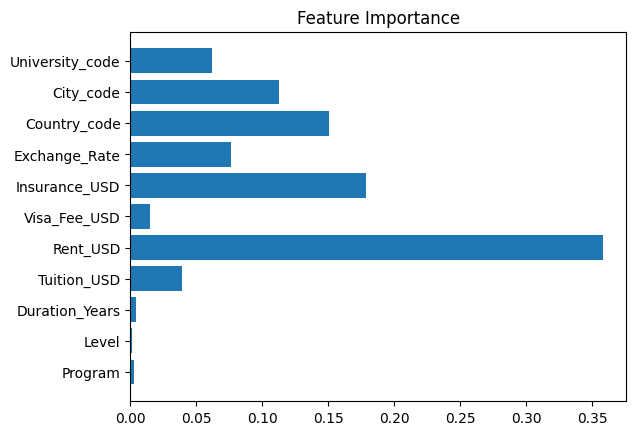

In [ ]:
import matplotlib.pyplot as plt

importance = model.feature_importances_ 
plt.barh(student.columns, importance)
plt.title("Feature Importance")
plt.show()


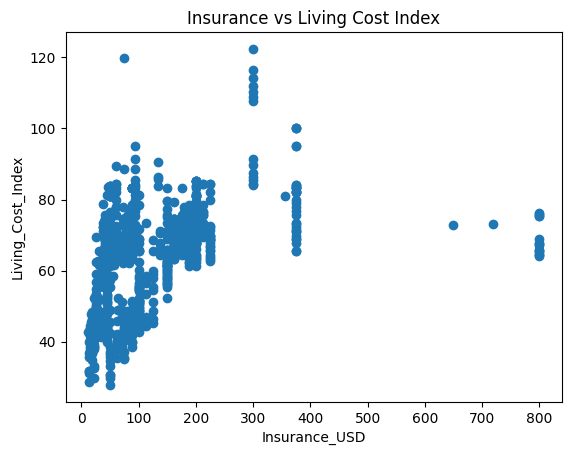

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(df['Insurance_USD'], df['Living_Cost_Index'])
plt.xlabel("Insurance_USD")
plt.ylabel("Living_Cost_Index")
plt.title("Insurance vs Living Cost Index")
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

cv_scores = cross_val_score(
    model, X, Y,
    cv=5,
    scoring="r2",
    n_jobs=-1
)
print("5-Fold R² scores:", np.round(cv_scores, 3))
print("Mean R²:", np.round(cv_scores.mean(), 3))


5-Fold R² scores: [0.8   0.478 0.412 0.747 0.853]
Mean R²: 0.658


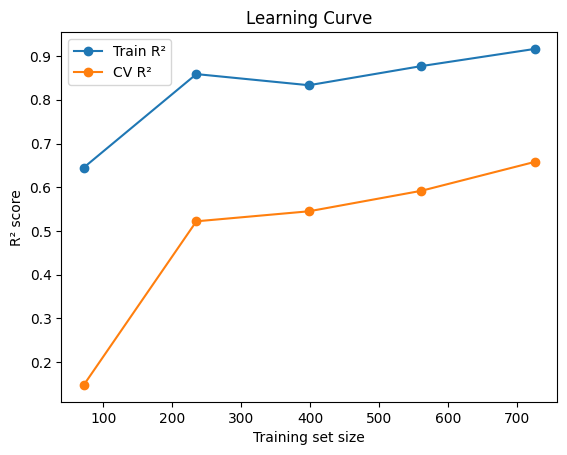

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    model, X, Y,
    train_sizes=np.linspace(0.1,1.0,5),
    cv=5,
    scoring="r2",
    n_jobs=-1
)
train_mean = train_scores.mean(axis=1)
val_mean   = val_scores.mean(axis=1)

plt.plot(train_sizes, train_mean, 'o-', label="Train R²")
plt.plot(train_sizes, val_mean,   'o-', label="CV R²")
plt.xlabel("Training set size")
plt.ylabel("R² score")
plt.legend()
plt.title("Learning Curve")
plt.show()


In [ ]:
#le=LabelEncoder()
#data["Country"]=le.fit_transform(data["Country"])
#data["City"]=le.fit_transform(data["City"])
#data["University"]=le.fit_transform(data["University"])
#data["Program"]=le.fit_transform(data["Program"])
#data["Level"]=le.fit_transform(data["Level"])
#plt.figure(figsize=(10,8))
#plt.title("Heatmap")
#sns.heatmap(data.corr(),annot=True)
#plt.show()